In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import sys
# sys.path.append('/Users/crazycatman/biomolecularmodelling/assignments/dna/pymdna/')
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2


def plot_curvature(curvature):
    # Create a colormap using seaborn
    cmap = mpl.colormaps['viridis']

    # Normalize the curvature data to fit within the colormap's range
    norm = mcolors.Normalize(vmin=curvature.min(), vmax=curvature.max())

    # Create a ScalarMappable with the normalization and colormap
    smappable = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Map each curvature value to a color using the ScalarMappable
    colors = smappable.to_rgba(curvature[0])

    # Create the plot
    fig, ax = plt.subplots(figsize=[12, 2])
    bars = ax.bar(x=range(len(curvature[0])), height=curvature[0]/10, color=colors)

    ax.set_xlabel('Base pair index')
    ax.set_ylabel('Curvature $[1/nm]$')
    ax.set_xlim(0, len(curvature[0]))

joblib is not installed. Falling back to sequential computation.


Load the pdb of a nucleosome (which is a protein that organizes DNA in the cell).

In [2]:
pdb = md.load('./data/nucleosome.pdb')
view = nv.show_mdtraj(pdb)
view

NGLWidget()

The DNA is wrapped around the protein, to characterize the dergree of wrapping we are going to analyze the curvature of the DNA. To do this you need to copy the `compute_curvature()` function defined in the `0_demo` notebook to the cell below:

In [3]:
# Paste the compute curvature function here: 

# Anwser:
def compute_curvature(points):
    # Calculate first derivatives along the points axis within each frame
    d_points = np.gradient(points, axis=1)
    
    # Compute unit tangent (T) and its derivative (T')
    # Norm calculation is along the last axis (x,y,z components), keepdims=True to maintain dimensions for broadcasting
    norm_d_points = np.linalg.norm(d_points, axis=-1, keepdims=True)
    T = d_points / norm_d_points
    dT = np.gradient(T, axis=1)
    
    # Compute curvature
    # The cross product and norm are computed along the last axis (x,y,z components)
    # The norm of d_points used in the denominator should also consider the correct axis for broadcasting
    curvature = np.linalg.norm(np.cross(dT, T), axis=-1) / np.power(norm_d_points[..., 0], 3)
    
    return curvature

To compute the curvature we also need to use the central coordinates of the rigid body base pair coordinates, the cell below extracts theses origins. You have to compute the curvature using the funcition above. 

In [4]:
# use origins of mean reference frames (mid triads of base pairs)
rigid = mdna.NucleicFrames(pdb)
frames = rigid.mean_reference_frames
origins = frames[:,:,0].swapaxes(0,1)

In [5]:
# compute the curvature
# # curtature = # call the function here
# anwser:
curvature = compute_curvature(origins)

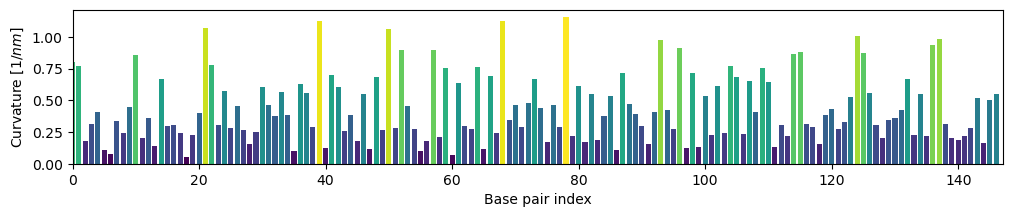

In [6]:
 # plot the curvature
plot_curvature(curvature)

Which top 5 base pais are the most curved? Use the `np.argsort` to find out. If you are not familiar with how this funciton works, you can always consult the Numpy documation, which is easily accessible online c~: You can use this function on the data stored inside `curvature`. And use the indices to find the base letters correspond to the most curved base pairs. To get the sequence you can use the function you finished in `1_compare_two_sequences`

In [7]:
# Awnser:
def get_sequence(traj):
    top = traj.topology
    sequence = ''
    chainid = top.chain(0).index
    for residue in top.chain(chainid).residues:
        sequence += residue.name[1]
    return sequence

# anwser:
sorted_base_pairs = np.argsort(curvature[0])[::-1]
sequence = get_sequence(pdb)
print('base:',''.join([sequence[i] for i in sorted_base_pairs[:5]]))
print('indices',sorted_base_pairs[:5])
print('curvature:',curvature[0][sorted_base_pairs[:5]])

base: GGCCA
indices [78 39 68 21 50]
curvature: [11.558936   11.23029145 11.21063366 10.6754892  10.62009305]


Next we want to know how long the DNA is. To compute this we can use one of the rigid base parameter, figure out which rigid base parameter is suitiable for this and give the anwser in nanometers. 

In [8]:
params, names = rigid.get_paramters()
print(params.shape, names)

(1, 147, 12) ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening', 'shift', 'slide', 'rise', 'tilt', 'roll', 'twist']


In [9]:
parameter_name = 'replace with_parameter_name'# fill in the parameter name based on the names variable above as a string
parameter_name = 'rise'
param = params[:,:,names.index(parameter_name)][0]

When you have determine which parameter to use manipulate the array in the cell below to find the total length of the DNA

In [10]:
# anwser:
total_length = np.sum(param) / 10 
print(f'Length of the DNA is {total_length} nm')

Length of the DNA is 48.53294060765192 nm
